In [1]:
import os
import glob

import numpy as np
import xarray as xr

import pandas as pd
import cftime

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo

# look at atmopsheric triggers
- repeat 3$\sigma$ change point analysis
- look at single member composites
    - Annual Surface Heat Flux
    - Winter Labrador SHF (D,J,F,M)
    - Annual Labrador Sea Wind
    - Annual SPG Wind
    - Winter Labrador Sea Wind (D,J,F,M)
    - Winter SPG Wind (D,J,F,M)
    - Annual NAO
- Plot averages together
- Compare triggers plot
- attempt at repeating same for 1$\sigma$ analysis

# 3 std

In [6]:
# Define parameters
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
h = 7
window_size = 40
duration_threshold = 20
threshold_multiple = 3

# Load signal data for the first plot
signals = np.load(raw_files[7])
hist_end = (2014 - 1850) * 12
signals = signals[:hist_end]
time_annual = np.arange(1850, 1850 + (hist_end / 12))

# Read the order file
with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
    vvel_list = file.readlines()
vvel_dict = {int(line.split()[0]): line.split()[1] for line in vvel_list}

# Load data from 'events_dens_spg.csv' to get member numbers
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)
member_numbers = data['Index']

# Process data for the first plot
last_member_name = vvel_dict[member_numbers[-3]][5:]
signal = signals[:, member_numbers[-3]][:hist_end]
annual_mean = np.mean(signal.reshape(-1, 12), axis=1)

# Identify events for the second plot
criteria_indices_dict = {}

for i, signal in enumerate(signals.T):
    annual_means = np.mean(signal.reshape(-1, 12), axis=1)
    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):
            if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
                print(j)
    criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

with open('events_dens_spg.csv', 'w', newline='') as csvfile:
    fieldnames = ['Index', 'Values']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, values in result:
        writer.writerow({'Index': index, 'Values': values[0]})

# Save event and member names
saved_data = []
for index, values in result:
    file_name = vvel_dict[index][5:-3]
    annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))

sorted_data = sorted(saved_data, key=lambda x: x[0])

120
105
64
141
40
56
55
121
79
41
89
107
57
56


In [3]:
# Extracting the 'Values' field
values = data['Values']

# Adding 1850 to each value
new_values = values + 1850

new_values

array([1970, 1955, 1914, 1991, 1890, 1906, 1905, 1971, 1929, 1891, 1957,
       1907, 1906])

In [7]:
mean_colors = cm.winter(np.linspace(0, 1, 8))

## Annual Surface Heat Flux

In [8]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    data = xr.open_dataarray(path+ 'monthly_shf_member_'+file_name+'.nc').values
    annual_means = np.mean(data.reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))
    
ann_lab_shf = sorted(saved_data, key=lambda x: x[0])

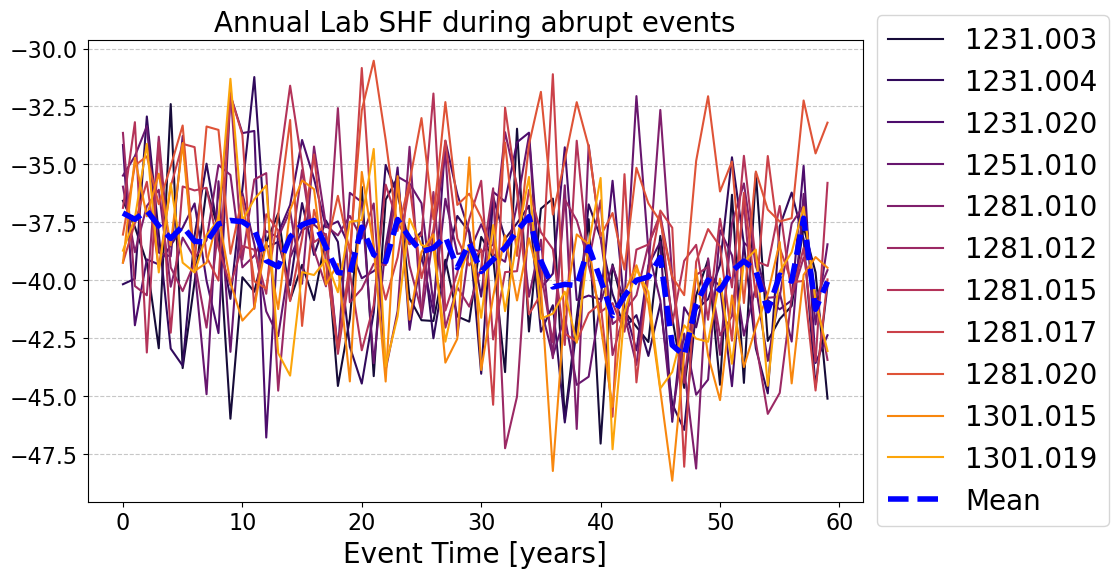

In [9]:
colors = cm.inferno(np.linspace(0.1, 0.8, len(ann_lab_shf[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))

for (file_name, timeseries), color in zip(ann_lab_shf[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
mean_ann_lab_shf = np.mean(time_series_list, axis=0)

ax.plot(mean_ann_lab_shf, label='Mean', linestyle='--', color=mean_colors[0], linewidth=4, zorder=110)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Annual Lab SHF during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Annual_Lab_SHF_Events.png', bbox_inches='tight', dpi=300)

## Winter Labrador SHF (D,J,F,M)

In [10]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    data = xr.open_dataarray(path+ 'monthly_shf_member_'+file_name+'.nc').values
    averages = []
    initial_group_mean = np.mean(data[:3]) #average of the first three entries
    averages.append(initial_group_mean)

    for i in range(11, len(data), 12): # averages of 4 values starting at the 12th entry
        group = data[i:i+4]
        group_mean = np.mean(group)
        averages.append(group_mean)

    djfm_means = np.array(averages)
    start = values[0]
    end = values[0] + duration_threshold
    event = djfm_means[start - window_size:end]
    saved_data.append((file_name, event))
    
djfm_lab_shf = sorted(saved_data, key=lambda x: x[0])

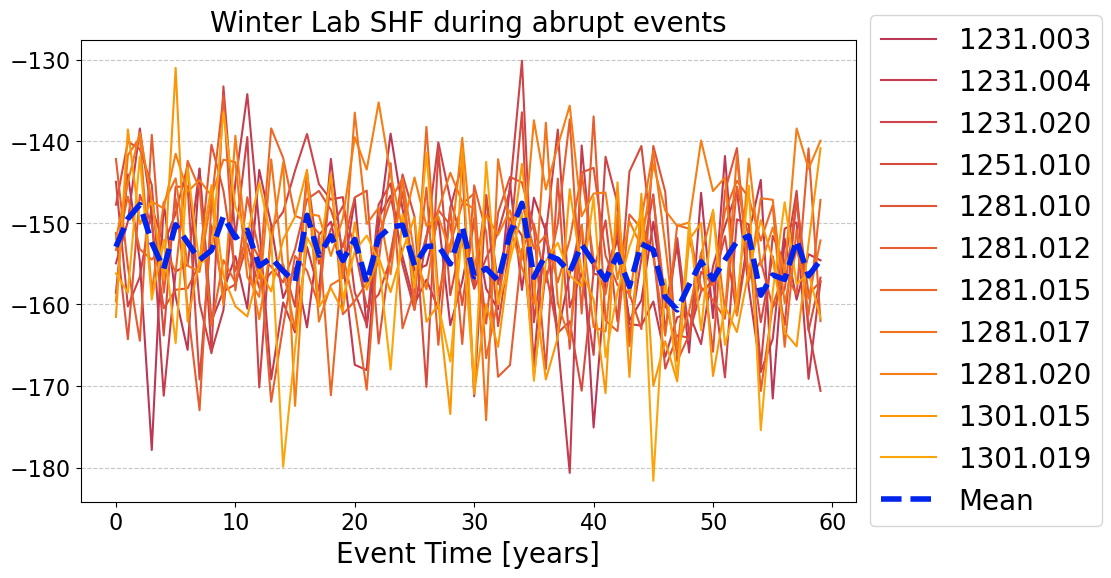

In [11]:
colors = cm.inferno(np.linspace(0.5, 0.8, len(djfm_lab_shf[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

for (file_name, timeseries), color in zip(djfm_lab_shf[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
        
mean_djfm_lab_shf = np.mean(time_series_list, axis=0)
ax.plot(mean_djfm_lab_shf, label='Mean', linestyle='--', color=mean_colors[1], linewidth=4, zorder=110)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Winter Lab SHF during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Winter_Lab_SHF_Events.png', bbox_inches='tight', dpi=300)

## Annual Labrador Sea Wind

In [12]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    #members_to_select.append(file_name)
    data = xr.open_dataarray(path+ 'monthly_tau_member_'+file_name+'.nc').values
    annual_means = np.mean(data.reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))
    
ann_lab_tau = sorted(saved_data, key=lambda x: x[0])

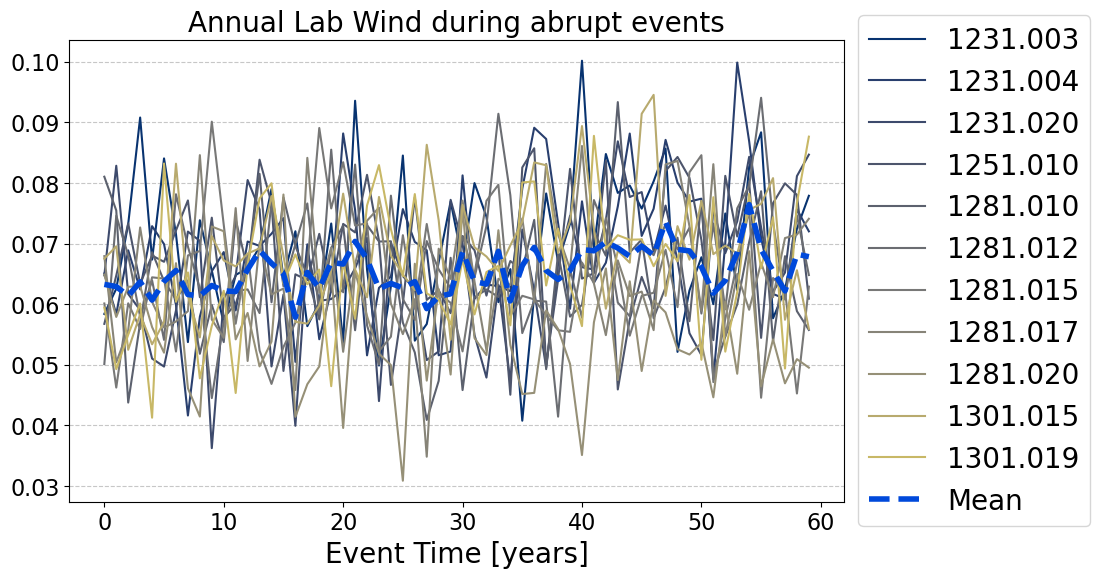

In [13]:
colors = cm.cividis(np.linspace(0.1, 0.8, len(ann_lab_tau[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))

for (file_name, timeseries), color in zip(ann_lab_tau[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
mean_ann_lab_tau = np.mean(time_series_list, axis=0)

ax.plot(mean_ann_lab_tau, label='Mean', linestyle='--', color=mean_colors[2], linewidth=4, zorder=110)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Annual Lab Wind during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Annual_Lab_Wind_Events.png', bbox_inches='tight', dpi=300)

## Annual SPG Wind

In [14]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    #members_to_select.append(file_name)
    data = xr.open_dataarray(path+ 'monthly_tau_spg_member_'+file_name+'.nc').values
    annual_means = np.mean(data.reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))
    
ann_spg_tau = sorted(saved_data, key=lambda x: x[0])

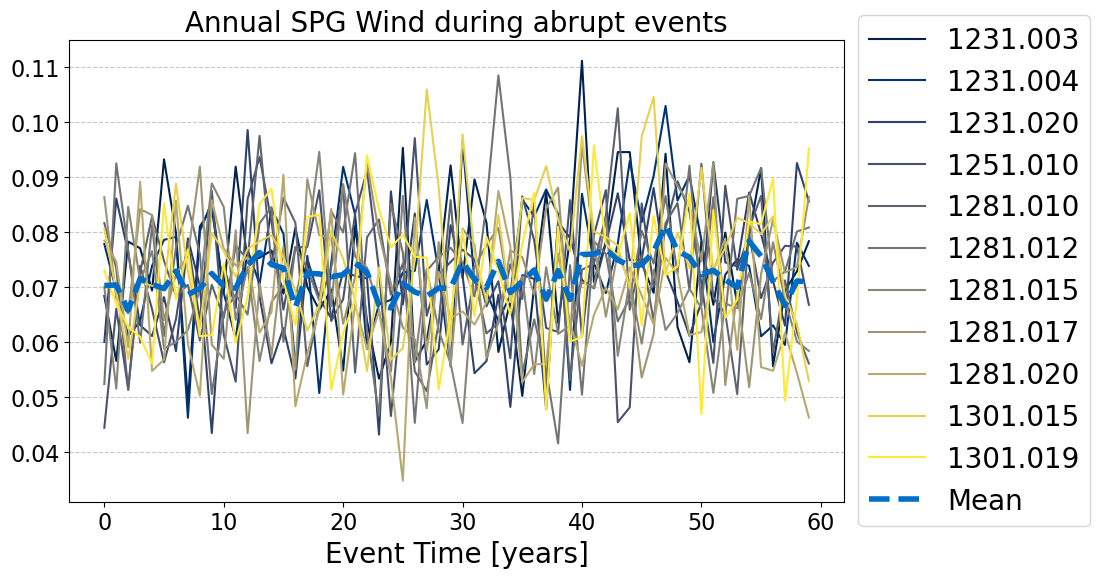

In [15]:
colors = cm.cividis(np.linspace(0, 1, len(ann_spg_tau[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))
for (file_name, timeseries), color in zip(ann_spg_tau[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
mean_ann_spg_tau = np.mean(time_series_list, axis=0)

ax.plot(mean_ann_spg_tau, label='Mean', linestyle='--', color=mean_colors[3], linewidth=4, zorder=110)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Annual SPG Wind during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Annual_SPG_Wind_Events.png', bbox_inches='tight', dpi=300)

## Winter Labrador Sea Wind (D,J,F,M)

In [16]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    data = xr.open_dataarray(path+ 'monthly_tau_member_'+file_name+'.nc').values
    
    averages = []
    initial_group_mean = np.mean(data[:3]) #average of the first three entries
    averages.append(initial_group_mean)

    for i in range(11, len(data), 12): # averages of 4 values starting at the 12th entry
        group = data[i:i+4]
        group_mean = np.mean(group)
        averages.append(group_mean)

    djfm_means = np.array(averages)
    start = values[0]
    end = values[0] + duration_threshold
    event = djfm_means[start - window_size:end]
    saved_data.append((file_name, event))
    
djfm_lab_tau = sorted(saved_data, key=lambda x: x[0])

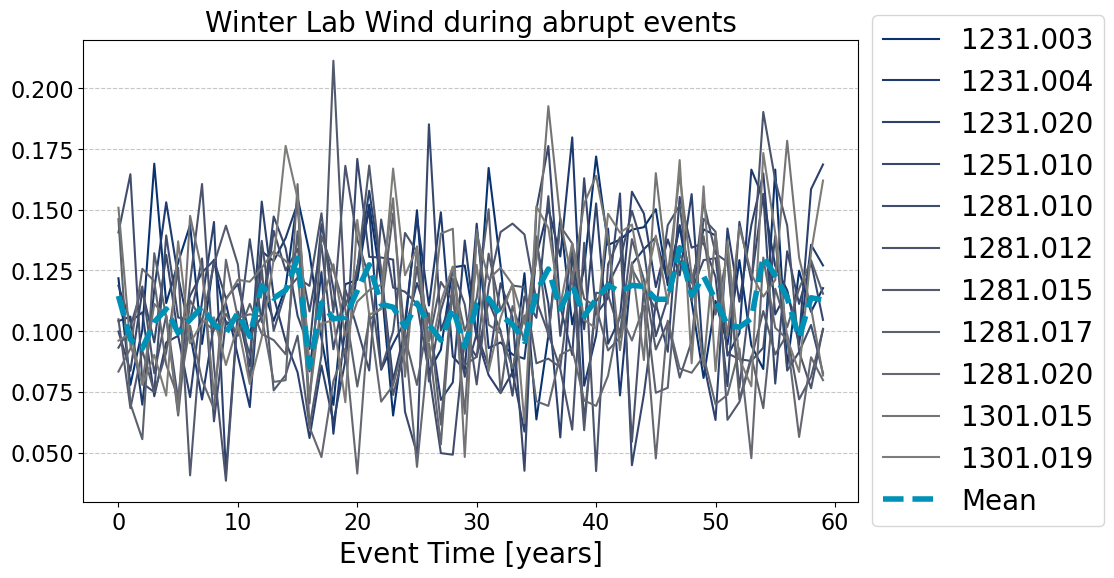

In [17]:
colors = cm.cividis(np.linspace(0.1, 0.5, len(djfm_lab_tau[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))

for (file_name, timeseries), color in zip(djfm_lab_tau[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
mean_djfm_lab_tau = np.mean(time_series_list, axis=0)

ax.plot(mean_djfm_lab_tau, label='Mean', linestyle='--', color=mean_colors[4], linewidth=4, zorder=110)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Winter Lab Wind during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Winter_Lab_Wind_Events.png', bbox_inches='tight', dpi=300)

## Winter SPG Wind (D,J,F,M)

In [18]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    data = xr.open_dataarray(path+ 'monthly_tau_spg_member_'+file_name+'.nc').values
    
    averages = []
    initial_group_mean = np.mean(data[:3]) #average of the first three entries
    averages.append(initial_group_mean)

    for i in range(11, len(data), 12): # averages of 4 values starting at the 12th entry
        group = data[i:i+4]
        group_mean = np.mean(group)
        averages.append(group_mean)

    djfm_means = np.array(averages)
    start = values[0]
    end = values[0] + duration_threshold
    event = djfm_means[start - window_size:end]
    saved_data.append((file_name, event))
    
djfm_spg_tau = sorted(saved_data, key=lambda x: x[0])

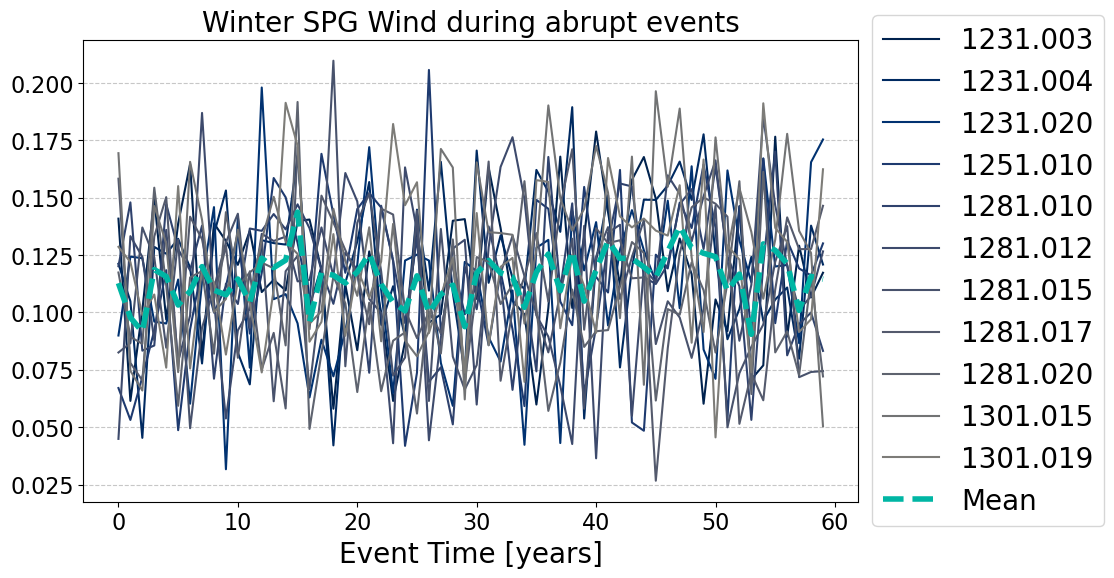

In [19]:
colors = cm.cividis(np.linspace(0, 0.5, len(djfm_spg_tau[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
for (file_name, timeseries), color in zip(djfm_spg_tau[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
        
mean_djfm_spg_tau = np.mean(time_series_list, axis=0)
ax.plot(mean_djfm_spg_tau, label='Mean', linestyle='--', color=mean_colors[5], linewidth=4, zorder=110)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Winter SPG Wind during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Winter_SPG_Wind_Events.png', bbox_inches='tight', dpi=300)

## Annual NAO

In [20]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
for index, value in result:
    file_name = vvel_dict[index][5:-3] 
    #members_to_select.append(file_name)
    ds = xr.open_dataset(path+ 'int_monthly_psl_pattern_'+file_name+'.nc')
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        ds['time'] = xr.DataArray(np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values]),dims='time')
    time_coord = ds.coords['time']
    data = ds.integrated_nao.values 
    
    annual_means = np.mean(data.reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))
    
ann_int_nao = sorted(saved_data, key=lambda x: x[0])

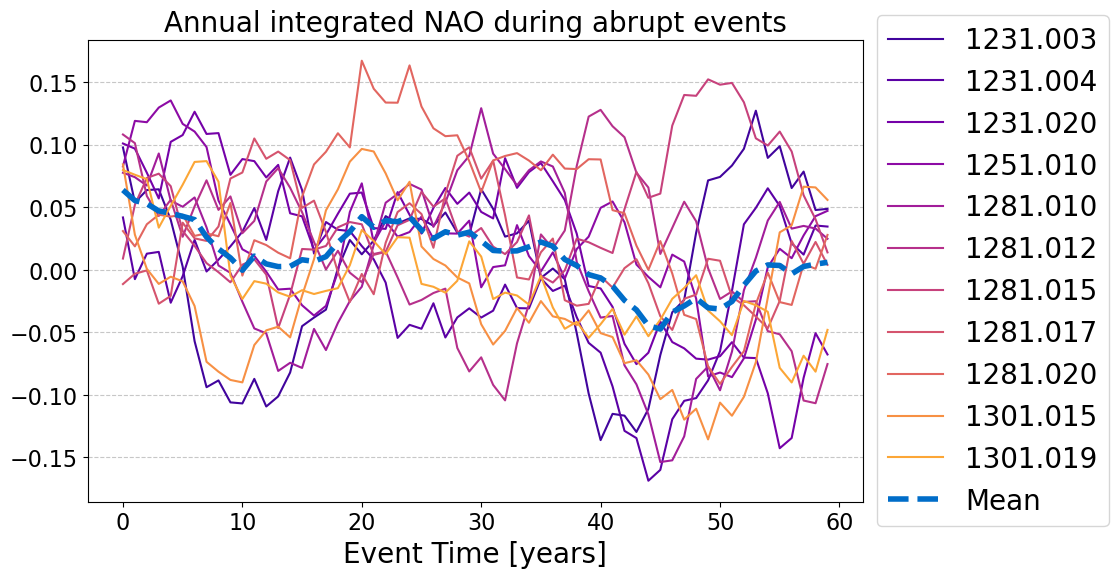

In [21]:
colors = cm.plasma(np.linspace(0.1, 0.8, len(ann_int_nao[1:])))
time_series_list = []

fig, ax = plt.subplots(figsize=(10, 6))
for (file_name, timeseries), color in zip(ann_int_nao[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
mean_ann_int_nao = np.mean(time_series_list, axis=0)

ax.plot(mean_ann_int_nao, label='Mean', linestyle='--', color=mean_colors[3], linewidth=4, zorder=110)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax.set_title(r'Annual integrated NAO during abrupt events', fontsize=20)
ax.set_xlabel('Event Time [years]', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Annual_int_NAO_Events.png', bbox_inches='tight', dpi=300)

## Plot averages together

In [22]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window = 5

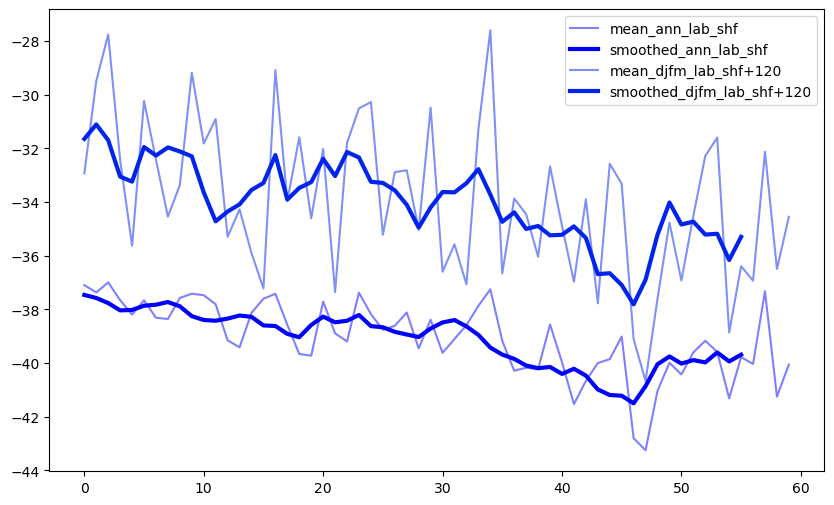

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mean_ann_lab_shf, label='mean_ann_lab_shf', color=mean_colors[0], alpha=.5)
ax.plot(moving_average(mean_ann_lab_shf, window), label='smoothed_ann_lab_shf', color=mean_colors[0], linewidth=3)
ax.plot(mean_djfm_lab_shf+120, label='mean_djfm_lab_shf+120', color=mean_colors[1], alpha=.5)
ax.plot(moving_average(mean_djfm_lab_shf+120, window), label='smoothed_djfm_lab_shf+120', color=mean_colors[1], linewidth=3)
ax.legend()
plt.show()

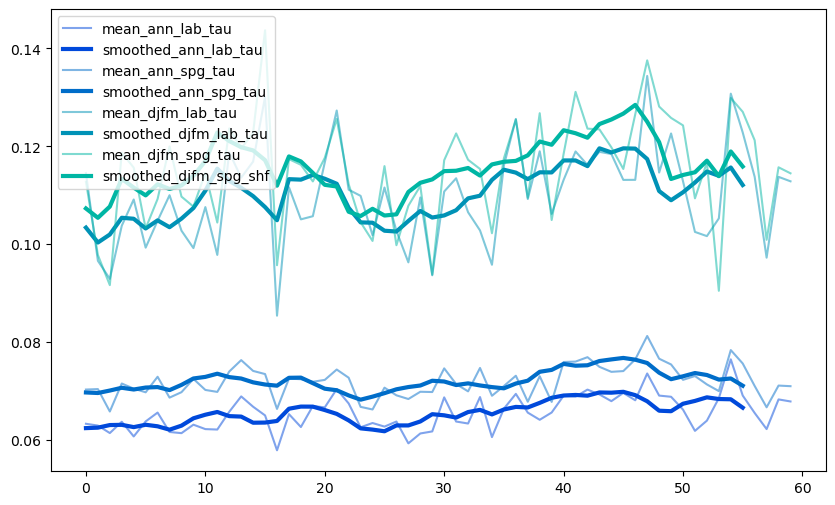

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mean_ann_lab_tau, label='mean_ann_lab_tau', color=mean_colors[2], alpha=0.5)
ax.plot(moving_average(mean_ann_lab_tau, window), label='smoothed_ann_lab_tau', color=mean_colors[2], linewidth=3)
ax.plot(mean_ann_spg_tau, label='mean_ann_spg_tau', color=mean_colors[3], alpha=0.5)
ax.plot(moving_average(mean_ann_spg_tau, window), label='smoothed_ann_spg_tau', color=mean_colors[3], linewidth=3)
ax.plot(mean_djfm_lab_tau, label='mean_djfm_lab_tau', color=mean_colors[4], alpha=0.5)
ax.plot(moving_average(mean_djfm_lab_tau, window), label='smoothed_djfm_lab_tau', color=mean_colors[4], linewidth=3)
ax.plot(mean_djfm_spg_tau, label='mean_djfm_spg_tau',color=mean_colors[5], alpha=0.5)
ax.plot(moving_average(mean_djfm_spg_tau, window), label='smoothed_djfm_spg_shf', color=mean_colors[5], linewidth=3)

ax.legend()
plt.show()

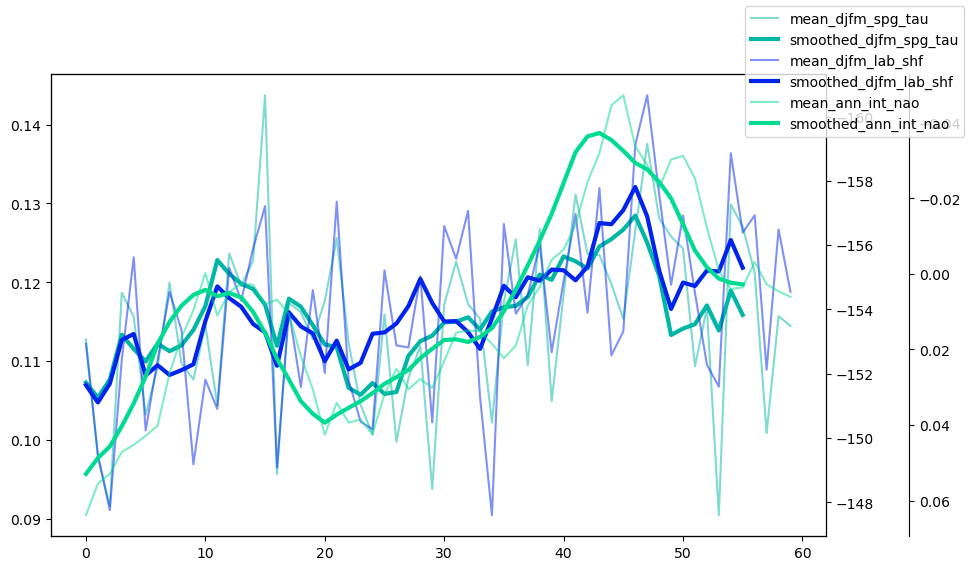

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

#ax1.plot(mean_djfm_lab_tau, label='mean_djfm_lab_tau', color=mean_colors[4], alpha=0.5)
#ax1.plot(moving_average(mean_djfm_lab_tau, window), label='smoothed_djfm_lab_tau', color=mean_colors[4], linewidth=3)

ax1.plot(mean_djfm_spg_tau, label='mean_djfm_spg_tau',color=mean_colors[5], alpha=0.5)
ax1.plot(moving_average(mean_djfm_spg_tau, window), label='smoothed_djfm_spg_tau', color=mean_colors[5], linewidth=3)



ax2 = ax1.twinx()
ax2.plot(mean_djfm_lab_shf, label='mean_djfm_lab_shf', color=mean_colors[1], alpha=.5)
ax2.plot(moving_average(mean_djfm_lab_shf, window), label='smoothed_djfm_lab_shf', color=mean_colors[1], linewidth=3)
ax2.invert_yaxis() 


ax3 = ax1.twinx()
ax3.plot(mean_ann_int_nao, label='mean_ann_int_nao', color=mean_colors[6], alpha=.5)
ax3.plot(moving_average(mean_ann_int_nao, window), label='smoothed_ann_int_nao', color=mean_colors[6], linewidth=3)
ax3.spines["right"].set_position(("outward", 60))
ax3.invert_yaxis() 

fig.legend()

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Comparison_TAU_SHF_NAO.png', bbox_inches='tight', dpi=300)

## Compare triggers plot

In [26]:
mean_delta_djfm_spg_tau = (mean_djfm_spg_tau - np.mean(mean_djfm_spg_tau[:40], axis=0)) / np.mean(mean_djfm_spg_tau[:40], axis=0)
mean_delta_djfm_lab_shf = (mean_djfm_lab_shf - np.mean(mean_djfm_lab_shf[:40], axis=0)) / np.mean(mean_djfm_lab_shf[:40], axis=0)
mean_delta_ann_spg_tau = (mean_ann_spg_tau - np.mean(mean_ann_spg_tau[:40], axis=0)) / np.mean(mean_ann_spg_tau[:40], axis=0)
mean_delta_ann_lab_shf = (mean_ann_lab_shf - np.mean(mean_ann_lab_shf[:40], axis=0)) / np.mean(mean_ann_lab_shf[:40], axis=0)
mean_delta_ann_int_nao = (mean_ann_int_nao - np.mean(mean_ann_int_nao[:40], axis=0)) / np.mean(mean_ann_int_nao[:40], axis=0)

std_delta_djfm_spg_tau = (mean_djfm_spg_tau - np.mean(mean_djfm_spg_tau[:40], axis=0)) / np.std(mean_djfm_spg_tau[:40], axis=0)
std_delta_djfm_lab_shf = (mean_djfm_lab_shf - np.mean(mean_djfm_lab_shf[:40], axis=0)) / np.std(mean_djfm_lab_shf[:40], axis=0)
std_delta_ann_spg_tau = (mean_ann_spg_tau - np.mean(mean_ann_spg_tau[:40], axis=0)) / np.std(mean_ann_spg_tau[:40], axis=0)
std_delta_ann_lab_shf = (mean_ann_lab_shf - np.mean(mean_ann_lab_shf[:40], axis=0)) / np.std(mean_ann_lab_shf[:40], axis=0)
std_delta_ann_int_nao = (mean_ann_int_nao - np.mean(mean_ann_int_nao[:40], axis=0)) / np.std(mean_ann_int_nao[:40], axis=0)

In [27]:
mean_delta_djfm_spg_tau = (mean_djfm_spg_tau - np.mean(mean_djfm_spg_tau, axis=0)) / np.mean(mean_djfm_spg_tau, axis=0)
mean_delta_djfm_lab_shf = (mean_djfm_lab_shf - np.mean(mean_djfm_lab_shf, axis=0)) / np.mean(mean_djfm_lab_shf, axis=0)
mean_delta_ann_spg_tau = (mean_ann_spg_tau - np.mean(mean_ann_spg_tau, axis=0)) / np.mean(mean_ann_spg_tau, axis=0)
mean_delta_ann_lab_shf = (mean_ann_lab_shf - np.mean(mean_ann_lab_shf, axis=0)) / np.mean(mean_ann_lab_shf, axis=0)
mean_delta_ann_int_nao = (mean_ann_int_nao - np.mean(mean_ann_int_nao, axis=0)) / np.mean(mean_ann_int_nao, axis=0)

std_delta_djfm_spg_tau = (mean_djfm_spg_tau - np.mean(mean_djfm_spg_tau, axis=0)) / np.std(mean_djfm_spg_tau, axis=0)
std_delta_djfm_lab_shf = (mean_djfm_lab_shf - np.mean(mean_djfm_lab_shf, axis=0)) / np.std(mean_djfm_lab_shf, axis=0)
std_delta_ann_spg_tau = (mean_ann_spg_tau - np.mean(mean_ann_spg_tau, axis=0)) / np.std(mean_ann_spg_tau, axis=0)
std_delta_ann_lab_shf = (mean_ann_lab_shf - np.mean(mean_ann_lab_shf, axis=0)) / np.std(mean_ann_lab_shf, axis=0)
std_delta_ann_int_nao = (mean_ann_int_nao - np.mean(mean_ann_int_nao, axis=0)) / np.std(mean_ann_int_nao, axis=0)

In [28]:
#time = slice(0,40)
time = slice(0,60)

# sMOC at 55°N
ds_sMOC = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')
smoc_55N = ds_sMOC.densMOC.isel(nlat=340-250).max('sigma')
mean_delta_smoc_55N = ((smoc_55N - smoc_55N.isel(time=time).mean('time'))/(smoc_55N.isel(time=time).mean('time'))).values
std_delta_smoc_55N = ((smoc_55N - smoc_55N.isel(time=time).mean('time'))/(smoc_55N.isel(time=time).std('time'))).values

## dMOC at 26°N
da_dMOC = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite.nc')
dmoc_26N = da_dMOC.isel(nlat=270).max('z_t')
mean_delta_dmoc_26N = ((dmoc_26N - dmoc_26N.isel(time=time).mean('time'))/(dmoc_26N.isel(time=time).mean('time'))).values
std_delta_dmoc_26N = ((dmoc_26N - dmoc_26N.isel(time=time).mean('time'))/(dmoc_26N.isel(time=time).std('time'))).values

# BSF
ds_bsf = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').roll(nlon=+100)#.where(mask_spg == 1)
bsf_spg = ds_bsf.min(dim=('nlat', 'nlon'))
mean_delta_bsf_spg = ((bsf_spg  - bsf_spg.isel(time=time).mean('time'))/(bsf_spg.isel(time=time).mean('time'))).values
std_delta_bsf_spg = ((bsf_spg  - bsf_spg.isel(time=time).mean('time'))/(bsf_spg.isel(time=time).std('time'))).values

In [33]:
# HMXL
ds_hmxl = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/HMXLcomposite.nc').roll(nlon=+100)#.where(mask_spg == 1)
hmxl_lab = ds_hmxl.mean(dim=('nlat', 'nlon'))
mean_delta_hmxl_lab = ((hmxl_lab  - hmxl_lab.isel(time=time).mean('time'))/(hmxl_lab.isel(time=time).mean('time'))).values
std_delta_hmxl_lab = ((hmxl_lab  - hmxl_lab.isel(time=time).mean('time'))/(hmxl_lab.isel(time=time).std('time'))).values

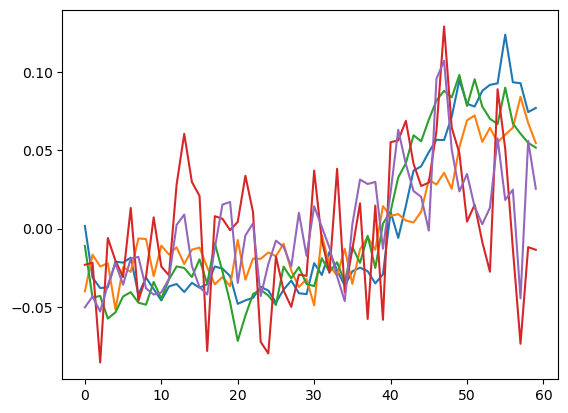

In [29]:
plt.plot(mean_delta_smoc_55N)
plt.plot(mean_delta_dmoc_26N)
plt.plot(mean_delta_bsf_spg)

plt.plot(mean_delta_ann_spg_tau)
plt.plot(mean_delta_ann_lab_shf)
#plt.plot(mean_delta_ann_int_nao)

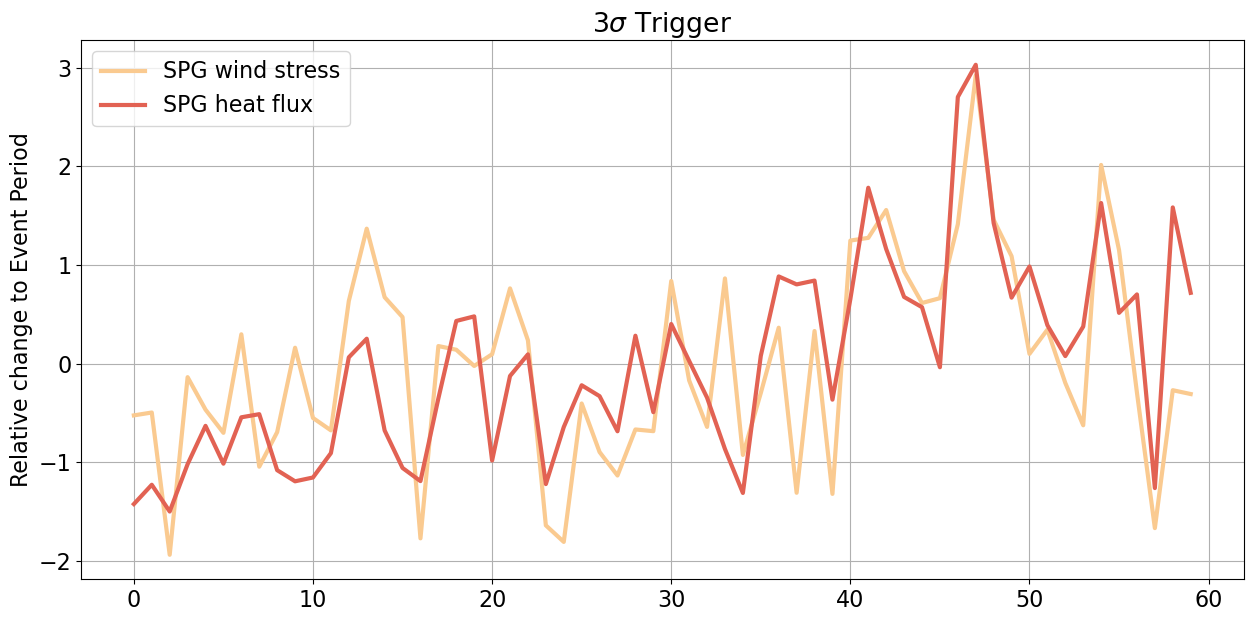

In [63]:
colors1 = cmo.haline(np.linspace(0.1, 0.8, 4))
colors2 = cmo.matter(np.linspace(0.1, 1, 4))

fig = plt.subplots(figsize=(15, 7))
plt.rc('font', size=16)

plt.plot(std_delta_ann_spg_tau, label='SPG wind stress', color=colors2[0], linewidth = 3)#, alpha=0.8)
plt.plot(-std_delta_ann_lab_shf, label='SPG heat flux', color=colors2[1], linewidth = 3)#, alpha=0.8)
#plt.plot(std_delta_ann_int_nao)

#plt.plot(std_delta_hmxl_lab, label='SPG mixed layer', color=colors2[3], linewidth = 3, linestyle='--')#, alpha=0.5)

#plt.plot(-std_delta_bsf_spg, label='SPG horizontal tranport', color=colors1[3], linewidth = 4)
#plt.plot(std_delta_smoc_55N, label=r'55$^{\circ}$N density overturning', color=colors1[0], linewidth = 4)
#plt.plot(std_delta_dmoc_26N, label=r'26.5$^{\circ}$N depth overturning', color=colors1[1], linewidth = 4)

plt.title(r'3$\sigma$ Trigger')

#moving_average(mean_djfm_lab_shf, window)

plt.ylabel('Relative change to Event Period')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 0.85))
plt.legend()

plt.grid()

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + '3sigma_Trigger_atmos.png', bbox_inches='tight', dpi=300, transparent=True)
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + '3sigma_Trigger_conv.png', bbox_inches='tight', dpi=300, transparent=True)
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + '3sigma_Trigger_comp.png', bbox_inches='tight', dpi=300, transparent=True)



# 1 std

In [13]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
saved_data = []
grouped = df.groupby('Index')

# set periods
before = 40*12
after = 20*12

# find file names 
def find_corresponding_file_name(vvel_number_to_find):
    with open(path+'timeseries/order.txt', 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

In [17]:
for index, group_data in grouped:
    for value, condition in zip(group_data['Values'], group_data['Condition']):
        if condition == "Above":
            file_name = vvel_dict[index][5:-3] 
            data = xr.open_dataarray(path+'monthly_tau_spg_member_'+file_name+'.nc').values
            annual_means = np.mean(data.reshape(-1, 12), axis=1)
            start = value
            end = value + duration_threshold
            event = annual_means[start - window_size:end]
            saved_data.append((file_name, event))
            
ann_lab_shf = sorted(saved_data, key=lambda x: x[0])

for (file_name, timeseries), color in zip(ann_lab_shf[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)
mean_ann_lab_shf = np.mean(time_series_list, axis=0)


In [28]:
file_patterns = [
    'monthly_tau_spg_member_', 
    'monthly_shf_member_', 
    #'monthly_smoc55_member_', 
    'max_dmoc_member_', 
    #'min_BSF_member_'
]

all_time_series = []
for pattern in file_patterns:
    print(pattern)
    saved_data = []
    for index, group_data in grouped:
        for value, condition in zip(group_data['Values'], group_data['Condition']):
            if condition == "Above":
                file_name = vvel_dict[index].strip()[5:-3]
                data_file_path = f"{path}{pattern}{file_name}.nc"
                if os.path.exists(data_file_path):
                    data = xr.open_dataarray(data_file_path).values
                    annual_means = np.mean(data.reshape(-1, 12), axis=1)
                    start = value
                    end = value + duration_threshold
                    event = annual_means[start - window_size:end]
                    saved_data.append(event)
    pattern_mean = np.mean(saved_data, axis=0)
    all_time_series.append(pattern_mean)
    


monthly_tau_spg_member_
monthly_shf_member_
max_dmoc_member_


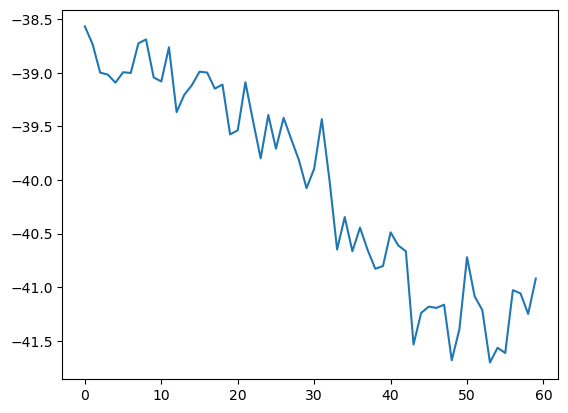

In [35]:
#plt.plot(all_time_series[0])
plt.plot(all_time_series[1])
#plt.plot(all_time_series[2])

In [36]:
mean_ann_spg_tau = np.array(all_time_series[0])
ean_ann_lab_shf = np.array(all_time_series[1])

std_delta_ann_spg_tau = (mean_ann_spg_tau - np.mean(mean_ann_spg_tau, axis=0)) / np.std(mean_ann_spg_tau, axis=0)
std_delta_ann_lab_shf = (mean_ann_lab_shf - np.mean(mean_ann_lab_shf, axis=0)) / np.std(mean_ann_lab_shf, axis=0)


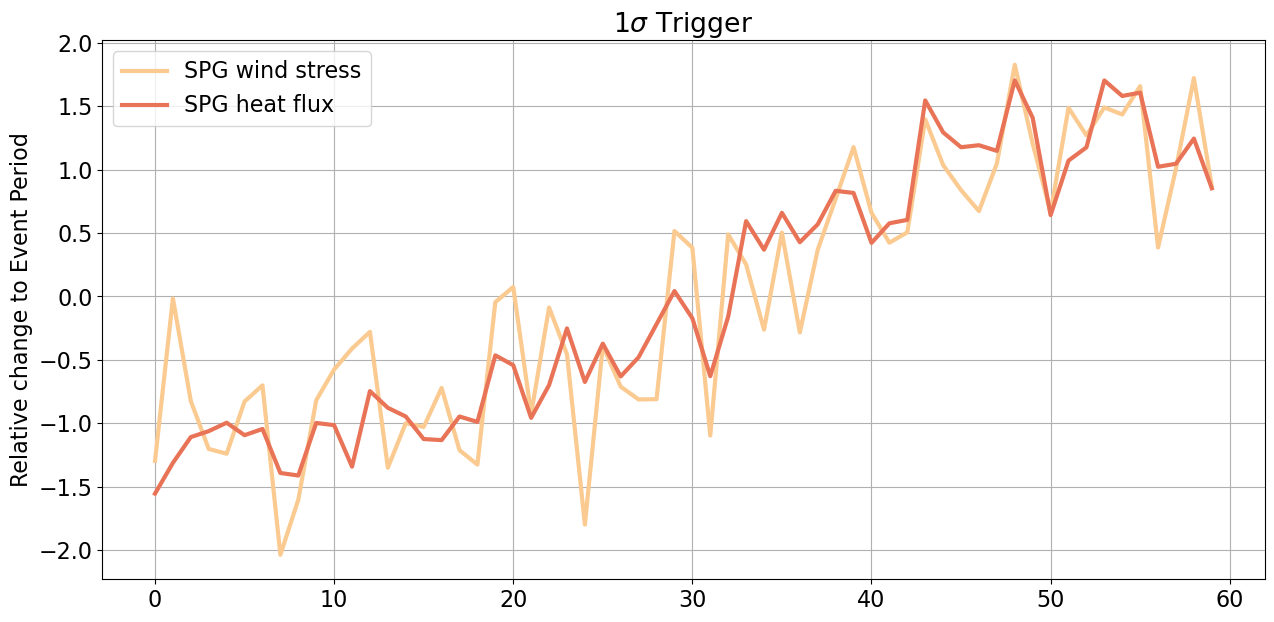

In [38]:
colors1 = cmo.haline(np.linspace(0.1, 0.8, 4))
colors2 = cmo.matter(np.linspace(0.1, 0.6, 3))

fig = plt.subplots(figsize=(15, 7))
plt.rc('font', size=16)



plt.plot(std_delta_ann_spg_tau, label='SPG wind stress', color=colors2[0], linewidth = 3)
plt.plot(-std_delta_ann_lab_shf, label='SPG heat flux', color=colors2[1], linewidth = 3)
#plt.plot(std_delta_ann_int_nao)


#moving_average(mean_djfm_lab_shf, window)

plt.ylabel('Relative change to Event Period')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 0.85))

plt.title(r'1$\sigma$ Trigger')
plt.legend()

plt.grid()

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + '1sigma_Trigger_comp.png', bbox_inches='tight', dpi=300)